# Analyzing Data from Airbnb's Seattle Market

### Business Context

An opportunity exists to analyze the vast amount of data collected by Airbnb and extract information that could help current and prospective landlords optimize their presence in the market. Data collected by Airbnb contains information from both the owners of listings as well as customers who have reviewed the properties, giving insight on both sides of the business. Given the dataset's breadth and depth of detail, multiple insights can be gained on the market. The focus of this notebook will be on determining how certain listing attributes affect the revenue of a property, as well as an investigation into whether or not a model can be trained to predict the price of a given listing. The three specific questions to be addressed are as follows:
- What style of accommodation  allows for highest revenue?
- What effect does distance from city center have on price?
- Can we predict price using categorical and quantitative values?

Answering the first two questions will lay the groundwork for other individual variable analyses. Once the code is in place to examine a variable's effect on revenue, any other independent variable can be analyzed in a similar way with minimal pre-processing. The prediction model will likely be more of a first step towards creating an accurate prediction. The scope of this project will not involve anything more than a built in scikit learn linear regression model. Given the complexity of the data and the mix of variables, it is possible the results from this model will not be sufficient for deployment in an actual business context, however it will be useful to demonstrate trends and illustrate whether or not a more complex algorithm might be able to better analyze the data.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns
import os
import re
import spacy
import ast
from geopy.distance import geodesic
from datetime import datetime, date
nlp = spacy.load('en')
from collections import Counter
%matplotlib inline

### Understanding the Available Data
I will now examine the different datasets provided. The formatting and linear regression will be tackled first, followed by analysis of the other two questions.

In [4]:
#The three available datasets are imported for further analysis.

list_df = pd.read_csv('./archive/listings.csv')
cal_df = pd.read_csv('./archive/calendar.csv')
review_df = pd.read_csv('./archive/reviews.csv')

In [5]:
cal_df.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


calendar.csv contains booking information for each listing with true or false variables for whether a listing was occupied on a given date as well as the price that was paid

In [6]:
review_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


review.csv contains different reviews written for listings.

In [7]:
list_df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


The listings dataset contains the fields of interest in analyzing the dataset. The calendar and reviews csv files are not needed for the purpose of this project. The following cell analyzed the size and data types contained in the file.

In [8]:
print('Shape:', list_df.shape)
print('Data types column count:')
print(list_df.dtypes.value_counts())

Shape: (3818, 92)
Data types column count:
object     62
float64    17
int64      13
dtype: int64


The dataset contains entries for 3818 listings with 92 variables per listing. These variables are represented by a mix of object, float64, and int64 data types. This indicates that a mix of quantitative and categorical variables can be found for each listing, complicating our analysis of the data.

Now that the types of data contained in the dataset are known, it is important to analyze missing values in the dataset. This will aid in determining which columns might not be useful in our analysis due to a lack of entries.

In [10]:
#Count the number of missing values and then sort in descending order
pd.set_option("max_rows", None)
list_df.isna().sum().sort_values(ascending=False)

license                             3818
square_feet                         3721
monthly_price                       2301
security_deposit                    1952
weekly_price                        1809
notes                               1606
neighborhood_overview               1032
cleaning_fee                        1030
transit                              934
host_about                           859
host_acceptance_rate                 773
review_scores_accuracy               658
review_scores_checkin                658
review_scores_value                  656
review_scores_location               655
review_scores_cleanliness            653
review_scores_communication          651
review_scores_rating                 647
reviews_per_month                    627
first_review                         627
last_review                          627
space                                569
host_response_time                   523
host_response_rate                   523
neighbourhood   

The missing values in some of these columns will need to be dealt with to accurately analyze the data. Certain columns containing missing values are not of interest, contain over 50 % missing values without an explanation, or are categorical variables containing a written description that is not within the scope of our analysis. These columns dropped completely (license, notes, neighborhood_overview, transit, host_about, first_review, last_review, space, any of the url vairables, summary, host_location). Monthly and weekly price variables will be dropped considering the price variable encompasses these values and is more universally listed in the dataset. Security_deposit, cleaning_fee, and extra_people are all columns that contain fee information where an absent value is likely an indication of a zero $ fee and the missing value will be replaced with 0. All other columns with missing values will have the missing entries filled with mean or mode values.

### Preparing the Data

The quantitative and categorical columns of interest are separated. A list of variables to drop is then created from any variable not found in the specified quantitative and categorical columns. test_df is created as a copy of list_df that will be used for the linear regression, while list_df is left as is except for a reformatting of its price column for further analysis.

In [11]:
quantitative = ['host_since', 'host_response_rate', 'host_acceptance_rate',
       'host_total_listings_count', 'accommodates', 'price', 'availability_365',
       'bathrooms', 'bedrooms', 'beds', 'square_feet', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'number_of_reviews','review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'reviews_per_month']

categorical = ['host_verifications', 'amenities','host_response_time','host_is_superhost',  
       'host_identity_verified', 'property_type', 'room_type', 'bed_type', 'instant_bookable', 'cancellation_policy', 
       'require_guest_profile_picture', 'require_guest_phone_verification', 'neighbourhood_group_cleansed',
       'requires_license', 'is_location_exact', 'has_availability']

# 'neighbourhood_cleansed', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'host_has_profile_pic',

In [12]:
drop_list = [i for i in list_df.columns if i not in quantitative+categorical]

In [13]:
test_df = list_df.drop(drop_list, axis=1)    

Certain columns that belong to each group must be transformed for accurate analysis. Columns in the date_cols category are in the format of "YYYY-MM-DD" as strings and must be transformed into a numerical count of the days since the indicated date. This quantitative variable should allow for meaningful information to be extracted as the larger the number, the more time has passed. Columns in the value_cols category are given as prices including dollar signs in a string format. These must be converted to floats to be analyzed. The rest of the quantitative variables (in num_cols) are already in float or int format and need no conversion.

list_cols indicates the categorical columns that contain a string list of values. These entries must be converted to a list and then each possible amenity or verification will be made into a single column with a 1 or 0 value for whether a listing contains that amenity/verification. This is necessary as creating dummy variables from the list entries would create dummy columns for each separate possible list, regardless of the amenities/verifications contained within that list.

In [14]:
date_cols = ['host_since']
value_cols = ['host_response_rate', 'host_acceptance_rate',
              'price', 'extra_people', 'security_deposit', 'cleaning_fee']

#columns in which a nan value represents a zero $ fee
nan_zero_cols = ['cleaning_fee', 'extra_people'] 

#columns in which nan values will be filled with the mode rather than the mean as a float value would not be realistic
nan_mode_cols = ['host_total_listings_count', 'accommodates',
               'bathrooms', 'bedrooms', 'beds','minimum_nights',
               'maximum_nights', 
               'availability_365', 'number_of_reviews'] 

num_cols = [i for i in quantitative if i not in date_cols+value_cols]

list_cols = ['host_verifications', 'amenities']
cat_cols = [i for i in categorical if i not in list_cols]

In [15]:
#reformat_date takes in a list of column names containing entries in a date format and replaces them with 
#a number of days since the date using the datetime library
def reformat_date(df, date_vars):
    '''
    INPUT:
    df - Pandas dataframe containing data formatted in a string date format
    date_vars - List of column names containing data formatted in a string date format
    
    OUTPUT
    df - Modified Pandas dataframe with dates now represented as a delta number of days to the current day
    '''
    
    for col in date_vars:
        for i in df[col].index:
            if not pd.isnull(df[col][i]):
                delta = date.today() - date.fromisoformat(df[col][i])
                df.loc[i, col] = delta.days
        df.loc[:, col] = df[col].astype(float)
        
    return df

test_df = reformat_date(test_df, date_cols)

In [16]:
#reformat_price takes in a list of column names containing entries in a price string format and replaces them with 
#a float value
def reformat_price(df, value_vars):
    '''
    INPUT:
    df - Pandas dataframe containing price data in a string format
    value_vars - List of column names containing price data in a string format
    
    OUTPUT
    df - Modified Pandas dataframe with price data now in an integer format
    '''
    
    for col in value_vars:
        for i in df[col].index:
            if not pd.isnull(df[col][i]):
                df.loc[i, col] = re.sub("[$,%]", "", df[col][i])
        df.loc[:, col] = df[col].astype(float)
    
    return df

test_df = reformat_price(test_df, value_cols)
list_df = reformat_price(list_df, value_cols)

In [17]:
#reformat_list takes in a list of column names containing entries in a string list format and replaces them with a 
#basic list that is then used to create dummy columns for each possible list entry value
def reformat_list(df, list_vars):
    '''
    INPUT:
    df - Pandas dataframe with data contained within lists in a string format
    list_vars - List of column names containing lists in a string format
    
    OUTPUT
    df - Modified Pandas dataframe now containing standard lists of strings
    '''
    
    for col in list_vars:
        new_col = []
        for i in df[col].index:
            if not pd.isnull(df[col][i]):
                if '{' in df[col][i]:
                    new_col.append(df[col][i].strip('{}').split(','))
                else:
                    new_col.append(ast.literal_eval(df[col][i]))
            else:
                new_col.append([])
        df = df.drop(col, axis=1)
        df = df.assign(temp=pd.Series(new_col).values)
        df = pd.concat([df.drop('temp', axis=1), pd.get_dummies(df['temp'].apply(pd.Series).stack()).sum(level=0)], axis=1)
    return df

test_df = reformat_list(test_df, list_cols)

In [18]:
#fill_null fills in all null values in the quantitative columns with the mean of the column, the mode, or a zero value
def fill_null(df, mode_cols, zero_cols):
    '''
    INPUT:
    df - Pandas dataframe with columns containing nan values
    mode_cols - List of column names containing data for which nan values will be 
                replaced with the mode of the column data
    zero_cols - List of column names containing data for which nan values will be 
                replaced with a zero value
    
    OUTPUT
    df - Modified Pandas dataframe with nan values now filled with the appropriate value
    '''
    
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        if col in zero_cols:
            df.loc[:, col].fillna(0, inplace=True)
        elif col in mode_cols:
            df.loc[:, col].fillna((df[col].mode()[0]), inplace=True)
        else:
            df.loc[:, col].fillna((df[col].mean()), inplace=True)
    return df

test_df = fill_null(test_df, nan_mode_cols, nan_zero_cols)

In [19]:
#dummy_columns generates dummy columns for a given list of categorical variables, dropping the original column
def dummy_columns(df, cat_vars):
    '''
    INPUT:
    df - Pandas dataframe with columns containing categorical variables
    mode_cols - List of column names containing categorical variables
    
    OUTPUT
    df - Modified Pandas dataframe with categorical values now replaced by dummy variable columns
    '''
    
    for col in cat_vars:
        try:
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], 
                 prefix=col, prefix_sep='_', dummy_na=False, drop_first=True)], axis=1)
        except:
            continue
    return df

test_df = dummy_columns(test_df, cat_cols)

## Data Modeling

### 1. Property Type Effect on Revenue

To analyze the first two questions I must first create a new column for revenue, combining price and availability over the next 365 days. Since test_df will be specifically modified for the linear regression, I will need a different copy of list_df, new_df. The revenue values will be sorted by property_type and plotted below.

In [20]:
new_col = []
for i in list_df['price'].index:
    if not pd.isnull(list_df['price'][i]):
        new_col.append(list_df['price'][i]*(365 - list_df['availability_365'][i]))
    else:
        new_col.append([])

new_df = list_df.assign(revenue=pd.Series(new_col).values)

In [21]:
rev_sorted = new_df.groupby(['property_type'])['revenue'].mean().sort_values(ascending=False)

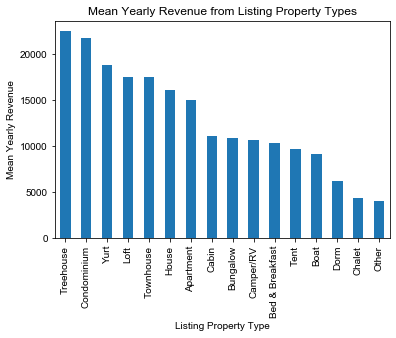

In [22]:
rev_sorted.plot(kind='bar', legend=None)
sns.set(rc={'figure.figsize':(8.7,4.27)})
plt.title('Mean Yearly Revenue from Listing Property Types')
plt.xlabel('Listing Property Type')
plt.ylabel('Mean Yearly Revenue')
plt.show()

These values were heavily skewed by the number of listings in each category, I therefore excluded any category with less than 10 listings from the next visualization after looking at the number of each listings available.

In [23]:
list_df['property_type'].value_counts()

House              1733
Apartment          1708
Townhouse           118
Condominium          91
Loft                 40
Bed & Breakfast      37
Other                22
Cabin                21
Camper/RV            13
Bungalow             13
Boat                  8
Tent                  5
Treehouse             3
Chalet                2
Dorm                  2
Yurt                  1
Name: property_type, dtype: int64

In [24]:
non_viable = []
for i in list_df['property_type'].value_counts().index:
    if list_df['property_type'].value_counts()[i] < 10:
        non_viable.append(i)
        
viable_rev_sorted = rev_sorted.drop(non_viable)

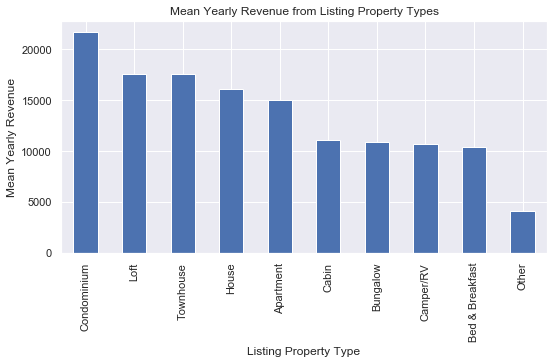

In [25]:
viable_rev_sorted.plot(kind='bar', legend=None)
sns.set(rc={'figure.figsize':(8.7,4.27)})
plt.title('Mean Yearly Revenue from Listing Property Types')
plt.xlabel('Listing Property Type')
plt.ylabel('Mean Yearly Revenue')
plt.show()

#### Evaluation
Condominiums generate the most revenue by a wide margin without oversaturating the market at the moment, making them an obvious choice for a landlord looking to put a new listing on Airbnb. Lofts and townhouses are other good options, while houses and apartments make up a massive portion of the market already, meaning there might be serious competition in that segment. A well planned treehouse or yurt clearly has the potential to generate even more revenue, however that segment is perhaps riskier given the lack of available data.

### 2. Distance Effect on Revenue

I will now create a column measuring the distance of each listing from a given city centre point generated from google maps. The python geopy library was used to calculate distance from longitude and latitude.

In [89]:
new_col = []
coords_dt = (47.605149, -122.334289)
for i in new_df.index:
    if not pd.isnull(new_df['latitude'][i]) and not pd.isnull(new_df['longitude'][i]):
        coords = (new_df['latitude'][i], new_df['longitude'][i])
        new_col.append(geodesic(coords, coords_dt).km)
    else:
        new_col.append([])

new_df = new_df.assign(distance_fromdt=pd.Series(new_col).values)

Distance is then plotted against revenue to identify trends in the data. Because of the large range in possible revenues, I thought it would be useful to plot an average revenue line as well, this is shown in the black dashed line.

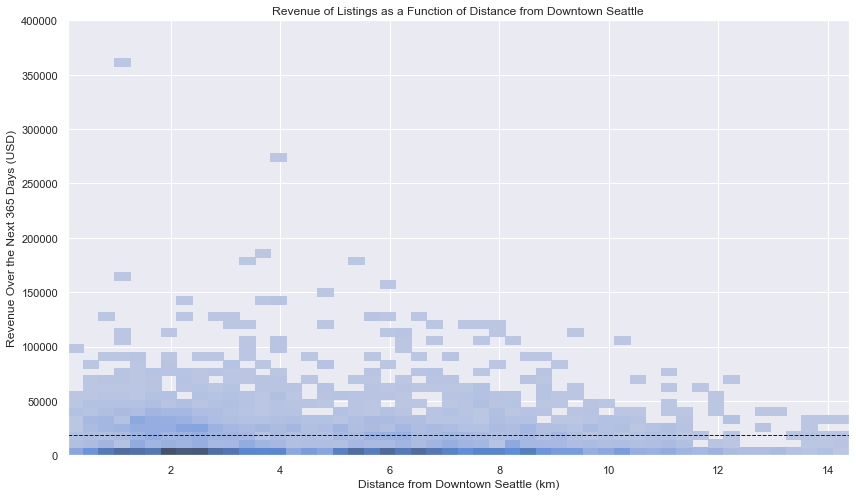

In [185]:
ax = sns.histplot(x='distance_from_dt', y='revenue', data=new_df, bins = 50)
sns.set(rc={'figure.figsize':(14, 8)}) 
ax.set(ylim=(0, 400000))
ax.set_title('Revenue of Listings as a Function of Distance from Downtown Seattle')
ax.set_ylabel('Revenue Over the Next 365 Days (USD)')
ax.set_xlabel('Distance from Downtown Seattle (km)')
plt.axhline(18924.753503184715, color='k', linestyle='dashed', linewidth=1)

#### Evaluation
There is a visible trend of increased revenue with decreased distance, though it is not incredibly steep when ignoring a few cash cow outliers. The nature of the histogram plot also gives a visualization of where the most properties are found, with a deeper blue colour for a higher concentration of listings. This shows a higher proportion of listings are found within 4 km of the downtown area. 

### 3. Linear Regression Price Predictions

test_df  has purely quantitative and dummy variables that can be analyzed by a linear regression model. For this, the dataset must be split into a y column of just the price values, and an X column containing all the independent variable columns without the price column. The folllowing cell splits the X and y matrices into training and test subsets and calls the scikit learn linear regression model, outputting the R2 score.

In [35]:
y = test_df['price']
X = test_df.drop(['price'], axis=1)    

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=28) 

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit

#Predict and score the model
y_test_preds = lm_model.predict(X_test) 
"The r-squared score for your model was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))

'The r-squared score for your model was 0.6438850251341349 on 1146 values.'

### Evaluation

This is not a great r-squared score, but does indicate the presence of a possible trend. To check if the proper data is being considered, I can investigate the coefficient weights.

In [37]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - Coefficients from the linear model
    X_train - Training data
    
    OUTPUT:
    coefs_df - dataframe containing the vairables and their coefficients (with absolute values)
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

coef_df = coef_weights(lm_model.coef_, X_train)
pd.set_option("max_rows", None)
coef_df

,est_int,coefs,abs_coefs
87,property_type_Boat,95.421373,95.421373
99,property_type_Treehouse,92.326050,92.326050
102,room_type_Shared room,-71.113031,71.113031
95,property_type_Loft,42.391948,42.391948
101,room_type_Private room,-40.899605,40.899605
62,"""Washer / Dryer""",39.208176,39.208176
68,Doorman,34.644653,34.644653
90,property_type_Camper/RV,32.158027,32.158027
38,weibo,30.888946,30.888946
91,property_type_Chalet,30.762759,30.762759


#### Evaluation
These coefficients seem to be of reasonable magnitude and those with the highest impact in both the negative and positive directions make sense. This leads to the conclusion that the linear regression model was picking up on a real trend, it just might not be the best algorithm to analyze this set of data.

## Conlcusion
This notebook examined methods to extract data from Airbnb's data on their Seattle marketplace. The data was examined and cleaned to allow for thorough analysis, with additional information such as revenue and distance from city center being extrapolated from the available variables. The questions that were specifically addressed were:
- What style of accommodation  allows for highest revenue?
    - It was determined that although treehouses generate the highest revenue on average, there are only three listings that fall into this category and further data would be needed to make an accurate judgment on that listing type. Out of the available data, it can be confidently stated that condominiums are the type of listing that generate the highest revenue.
- What effect does distance from city center have on price?
    - After extrapolating distance from city center using the latitude and longitude data, it was determined that listings closer to the downtown area generally generate a higher revenue, though there are also more properties in this area, leading to increased competition. Listings significantly outperform the average revenue all throughout the distances examined.
- Can we predict price using categorical and quantitative values?
    - Extracting a trend from the data for accurately predicting listing price is possible, although it was shown that a basic linear regression model does not do this to a sufficiently precise degree. The variables that had the highest impact on the price prediction were logical, and the possibilities for a tool that leverages the trends in the data are promising and would be very helpful for breaking into this market.
    
Further modelling with the cleaned data should be done, as well as any other analysis of the effect of independent variables on listing revenue. It would also be interesting to incorporate sentiment analysis of customer reviews into the price predictions for the listing as it could reveal more details about the listing that would be not available in data only provided by the property owner.

